# Testing
## Messwerte der Wetterstationen der Wasserschutzpolizei Zürich
Datum: 21.12.2021

### Importiere die notwendigen Packages

In [3]:
#%pip install openpyxl geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [4]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import time


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [70]:
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [71]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")



Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [72]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2021 12 datenstand:  10 time.struct_time(tm_year=2021, tm_mon=12, tm_mday=21, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=355, tm_isdst=-1)


### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen

In [73]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [74]:
# Filepath
if status == "prod":
    #fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/BEV325OD3250.csv"
    fp_my = r"https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_mythenquai_2007-2020.csv"
    fp_tb = r"https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_tiefenbrunnen_2007-2020.csv"
else:
    fp_my = r"https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_mythenquai_2007-2020.csv"
    fp_tb = r"https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_tiefenbrunnen_2007-2020.csv"


print(fp_my, fp_tb)

https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_mythenquai_2007-2020.csv https://data.stadt-zuerich.ch/dataset/sid_wapo_wetterstationen/download/messwerte_tiefenbrunnen_2007-2020.csv


#### Parsing & Formatting Strings to Dataframes
- [**Cheat Sheet**](https://strftime.org/)
- Python documentation for **strptime**: [string **parse** time, Python 3](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
- Python documentation for strptime/**strftime**: [string **format** time,Python 3](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)



In [75]:
# Read the data
data2betested_my = pd.read_csv(
    fp_my, 
    sep=',',
    parse_dates=['timestamp_utc', 'timestamp_cet'],
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'),
    low_memory=False    
    )

print('done')

done


In [76]:
# Read the data
data2betested_tb = pd.read_csv(
    fp_tb, 
    sep=',',
    parse_dates=['timestamp_utc'],
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'),
    low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [77]:
data2betested_my.head(2)
data2betested_my.dtypes

timestamp_utc              datetime64[ns, UTC]
timestamp_cet                           object
air_temperature                        float64
water_temperature                      float64
wind_gust_max_10min                    float64
wind_speed_avg_10min                   float64
wind_force_avg_10min                   float64
wind_direction                           int64
windchill                              float64
barometric_pressure_qfe                float64
precipitation                          float64
dew_point                              float64
global_radiation                       float64
humidity                                 int64
water_level                            float64
dtype: object

In [78]:
data2betested_tb.head(2)
data2betested_tb.dtypes

timestamp_utc              datetime64[ns, UTC]
timestamp_cet                           object
air_temperature                        float64
water_temperature                      float64
wind_gust_max_10min                    float64
wind_speed_avg_10min                   float64
wind_force_avg_10min                   float64
wind_direction                           int64
windchill                              float64
barometric_pressure_qfe                float64
precipitation                          float64
dew_point                              float64
global_radiation                       float64
humidity                                 int64
water_level                            float64
dtype: object

In [82]:
#data2betested_my.shape
data2betested_tb.shape

(704988, 15)

Beschreibe einzelne Attribute

In [83]:
data2betested_my.describe()
data2betested_tb.describe()

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
count,704988.0,704988.0,704988.0,704988.0,704988.0,704988.0,704988.0,704988.0,0.0,704988.0,0.0,704988.0,0.0
mean,11.5,13.3,2.6,1.2,1.1,157.5,10.8,970.1,NaN,6.9,NaN,75.6,NaN
std,7.9,6.7,2.7,1.5,1.4,107.4,8.2,7.9,NaN,6.4,NaN,15.2,NaN
min,-14.0,0.0,0.0,0.0,0.0,0.0,-20.5,930.7,NaN,-17.5,NaN,17.0,NaN
25%,5.2,6.6,0.9,0.1,0.1,55.0,4.1,965.9,NaN,2.1,NaN,66.0,NaN
50%,11.4,13.0,1.8,0.7,0.8,153.0,10.8,970.3,NaN,7.0,NaN,78.0,NaN
75%,17.5,19.4,3.5,1.6,1.6,255.0,17.1,974.8,NaN,12.1,NaN,87.0,NaN
max,35.8,70.0,35.0,21.9,21.9,360.0,92.6,1024.0,NaN,70.0,NaN,104.0,NaN


Wie viele Nullwerte gibt es im Datensatz?

In [84]:
data2betested_my.isnull().sum()

timestamp_utc                  0
timestamp_cet                  0
air_temperature                0
water_temperature          49642
wind_gust_max_10min            0
wind_speed_avg_10min           0
wind_force_avg_10min           0
wind_direction                 0
windchill                      0
barometric_pressure_qfe     4741
precipitation              49642
dew_point                      0
global_radiation           49642
humidity                       0
water_level                49642
dtype: int64

In [85]:
data2betested_tb.isnull().sum()

timestamp_utc                   0
timestamp_cet                   0
air_temperature                 0
water_temperature               0
wind_gust_max_10min             0
wind_speed_avg_10min            0
wind_force_avg_10min            0
wind_direction                  0
windchill                       0
barometric_pressure_qfe         0
precipitation              704988
dew_point                       0
global_radiation           704988
humidity                        0
water_level                704988
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [86]:
data2betested_my = data2betested_my.set_index("timestamp_utc")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

In [87]:
data2betested_my.info()
data2betested_my.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708364 entries, 2007-04-22 19:20:00+00:00 to 2020-12-31 23:00:00+00:00
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   timestamp_cet            708364 non-null  object 
 1   air_temperature          708364 non-null  float64
 2   water_temperature        658722 non-null  float64
 3   wind_gust_max_10min      708364 non-null  float64
 4   wind_speed_avg_10min     708364 non-null  float64
 5   wind_force_avg_10min     708364 non-null  float64
 6   wind_direction           708364 non-null  int64  
 7   windchill                708364 non-null  float64
 8   barometric_pressure_qfe  703623 non-null  float64
 9   precipitation            658722 non-null  float64
 10  dew_point                708364 non-null  float64
 11  global_radiation         658722 non-null  float64
 12  humidity                 708364 non-null  int64  
 13  water_level  

Int64Index([22, 23, 24, 25, 26, 27, 28, 29, 30,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
            14, 15, 16, 17, 18, 19, 20, 21, 31],
           dtype='int64', name='timestamp_utc')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [88]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

NameError: name 'data2betested' is not defined

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [89]:
data2betested_my.loc["2017-06-30"]
data2betested_my.loc["2017-10-04":"2017-12-06"].head(2)

,timestamp_cet,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
timestamp_utc,,,,,,,,,,,,,,
2017-10-04 00:00:00+00:00,2017-10-04 02:00:00+02:00,11.7,17.3,4.5,3.1,3.1,320,8.8,978.0,0.0,7.7,0.0,76,406.0
2017-10-04 00:10:00+00:00,2017-10-04 02:10:00+02:00,11.7,17.3,3.8,2.3,2.3,324,10.3,977.9,0.0,7.6,0.0,76,406.0


### Aggriere Werte nach Zeitausschnitten

Mit den Funktionen zur Zeit kann einfach zwischen Stunden, Tagen, Monaten, etc. gewechselt und aggregiert werden.


In [93]:
bsp_median = data2betested_my.resample("M").median().head(10)
bsp_median

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
timestamp_utc,,,,,,,,,,,,,
2007-04-30 00:00:00+00:00,17.8,17.4,2.5,1.4,1.4,162.5,17.0,970.1,0.0,8.2,31.5,55.0,405.9
2007-05-31 00:00:00+00:00,15.6,15.9,3.7,1.9,1.9,203.0,14.5,965.9,0.0,8.2,36.5,65.0,406.0
2007-06-30 00:00:00+00:00,18.3,20.6,3.2,1.7,1.7,198.0,17.8,966.8,0.0,12.1,49.0,70.0,406.1
2007-07-31 00:00:00+00:00,18.3,19.9,3.3,1.7,1.7,216.0,17.6,969.8,0.0,12.0,38.0,70.0,406.1
2007-08-31 00:00:00+00:00,17.8,21.1,2.6,1.3,1.3,214.0,17.3,967.1,0.0,12.6,21.0,78.0,406.1
2007-09-30 00:00:00+00:00,14.0,18.5,2.6,1.4,1.4,256.5,13.5,973.8,0.0,8.6,9.0,75.0,406.1
2007-10-31 00:00:00+00:00,9.7,15.9,2.7,1.5,1.5,168.0,9.3,974.6,0.0,6.2,5.0,79.0,405.9
2007-11-30 00:00:00+00:00,4.9,8.2,3.4,1.7,1.7,235.0,3.1,973.2,0.0,0.3,5.0,79.0,405.9
2007-12-31 00:00:00+00:00,0.9,6.4,3.5,1.8,1.8,199.0,-0.7,980.0,0.0,-1.4,5.0,83.0,405.9


In [91]:
# first we create the sums per week
weekly_medians = data2betested_my.resample("W").median()
# then we generate the weekly means for each quarter
quarterly_medians = data2betested_my.resample("Q").median()
# for readability we'll revert the values back to integers
quarterly_medians.dropna().astype(int).head(2)

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
timestamp_utc,,,,,,,,,,,,,
2007-06-30 00:00:00+00:00,17,17,3,1,1,195,16,966,0,9,43,65,406
2007-09-30 00:00:00+00:00,16,19,2,1,1,225,16,970,0,11,23,75,406


### Visualisierungen nach Zeitausschnitten

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [105]:
weekly_medians.dtypes
weekly_medians.loc["2017-10-04":"2020-12-06"]

,air_temperature,water_temperature,wind_gust_max_10min,wind_speed_avg_10min,wind_force_avg_10min,wind_direction,windchill,barometric_pressure_qfe,precipitation,dew_point,global_radiation,humidity,water_level
timestamp_utc,,,,,,,,,,,,,
2017-10-08 00:00:00+00:00,12.4,17.1,3.3,1.8,1.8,220.0,11.9,973.0,0.0,9.0,0.0,77.0,406.0
2017-10-15 00:00:00+00:00,13.2,16.3,2.0,1.3,1.3,169.0,12.9,977.6,0.0,10.5,0.0,87.0,406.0
2017-10-22 00:00:00+00:00,13.1,16.2,2.3,1.6,1.6,165.0,12.6,970.3,0.0,9.8,0.0,78.0,405.9
2017-10-29 00:00:00+00:00,9.9,15.0,2.9,1.8,1.8,166.0,9.1,977.2,0.0,7.6,0.0,84.0,405.9
2017-11-05 00:00:00+00:00,8.6,13.0,2.8,1.8,1.8,159.0,7.6,969.9,0.0,5.4,0.0,82.0,405.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-08 00:00:00+00:00,9.3,NaN,3.4,2.1,2.0,155.5,7.9,1029.0,NaN,7.0,NaN,86.0,NaN
2020-11-15 00:00:00+00:00,8.3,NaN,2.0,1.3,1.0,172.0,7.9,1024.0,NaN,7.0,NaN,92.0,NaN
2020-11-22 00:00:00+00:00,6.7,NaN,2.7,1.7,2.0,270.0,6.0,1030.0,NaN,4.2,NaN,82.0,NaN


In [110]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['air_temperature'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(weekly_medians).encode(
    #x=weekly_medians.loc["2017-10-04":"2020-12-06"],
    y='water_temperature',
    color='air_temperature'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

alt.LayerChart(...)

In [69]:
alt.Chart(mySelection).mark_circle(size=60).encode(
    x='StichtagDatJahr',
    y='AlterV20Kurz',
    #color='AnzNat',
    #color=alt.Color('AnzNat', scale=alt.Scale(scheme='dark2')),
    color=alt.Color('AlterV20Kurz', scale=alt.Scale(scheme='greens')),
    tooltip=['StichtagDatJahr','AlterV20Kurz','AnzBestWir']
).interactive() # this makes the axes interactive: now you can zoom & pan




ValueError: Hierarchical indices not supported

alt.Chart(...)

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [25]:
myGraph = myTimeSelection.groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(

    {
        'AnzBestWir':'sum',
    }
)
myGraph.head()


#myTimeSelection



AnzBestWir
StichtagDatJahr StichtagDatMM QuarCd QuarLang               
2021            7             11     Rathaus            3238
                              12     Hochschulen         677
                              13     Lindenhof          1020
                              14     City                818
                              21     Wollishofen       20020

In [26]:
stats_agg_quartiere = myGraph.groupby(['StichtagDatJahr', 'QuarCd','QuarLang'])[['AnzBestWir']].sum()
#stats_agg_quartiere=aktuellesJahr.groupby(['Jahr', 'QuarSort'])['AnzWhg','Wohnungsfl', 'PersInGeb'].sum()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()
#stats_agg_quartiere.head()
stats_agg_quartiere.head(3)

AnzBestWir
StichtagDatJahr QuarCd QuarLang               
2021            11     Rathaus            3238
                12     Hochschulen         677
                13     Lindenhof          1020

In [27]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(stats_agg_quartiere, on='QuarCd')

stadtquartiere_shapes_joined.head(13)


,geometry,QuarCd,qname,knr,AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7396
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5540
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,6404
3,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ...",81,Seefeld,8,5811
4,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ...",41,Werd,4,4603
5,"POLYGON ((8.51937 47.37478, 8.51946 47.37465, ...",34,Sihlfeld,3,21580
6,"POLYGON ((8.50127 47.37961, 8.50121 47.37957, ...",91,Albisrieden,9,22236
7,"POLYGON ((8.58346 47.38831, 8.58418 47.38833, ...",72,Hottingen,7,11213
8,"POLYGON ((8.54297 47.33543, 8.54285 47.33537, ...",21,Wollishofen,2,20020
9,"POLYGON ((8.52688 47.40709, 8.52687 47.40711, ...",61,Unterstrass,6,24368


<AxesSubplot:>

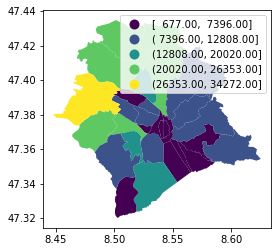

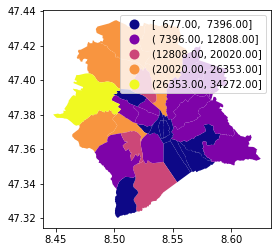

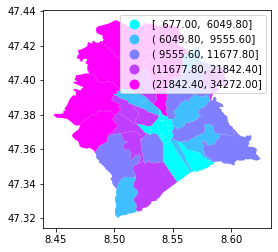

In [28]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**